<a href="https://colab.research.google.com/github/fsomba/computervision/blob/master/CropDaktari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print('\n',tf.__version__)


 2.0.0


In [ ]:
#load google drive and #get access
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import zipfile
#google drive zip file with dataset
local_zip = '/content/drive/My Drive/datasets/maize_data.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
#extract the zip to /tmp folder in colab
zip_ref.extractall('/tmp')
zip_ref.close()
print('\nsuccess. temporary dataset folder created\n')

import os
#verify folders
# Define base directories
base_dir = '/tmp/maize_data'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

#print folders in train_dir
train_folders=os.listdir(train_dir)
print(len(train_folders),'train folders found')

#print folders in train_dir
val_folders=os.listdir(train_dir)
print(len(val_folders),'validation folders found')


success. temporary dataset folder created

4 train folders found
4 validation folders found


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Add our data-augmentation parameters to train ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  #rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode='nearest',
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (256, 256))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (256, 256))

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
#quant is the mobile friendly version
from tensorflow.keras import optimizers

IMG_SHAPE = (256, 256, 3)
# create the base pre-trained model
base_model = Xception(input_shape=IMG_SHAPE,
                      include_top=False, 
                      weights='imagenet')

# i.e. freeze all convolutional InceptionV3 layers
#base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(4, activation='softmax')
]) 
'''
# add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = tf.keras.layers.Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)
# create the full network so we can train on it
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
'''

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.0005,momentum=0.9),
              metrics=['accuracy'])

print('\n model compiled','\n')

83689472/83683744 [==============================] - 3s 0us/step

 model compiled 



In [ ]:
#code to stop training once it reaches a certain accuracy
import tensorflow as tf

DESIRED_ACCURACY = 0.995

class myCallback(tf.keras.callbacks.Callback): #extends class
    #override method
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>DESIRED_ACCURACY):
            print("\ncancelling training! accuracy is at:",DESIRED_ACCURACY)
            self.model.stop_training = True

callbacks = myCallback()

history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 20,
            epochs = 150,
            validation_steps = 5,
            callbacks=[callbacks],
            verbose = 1)
            #use_multiprocessing=True,
            #workers=2)

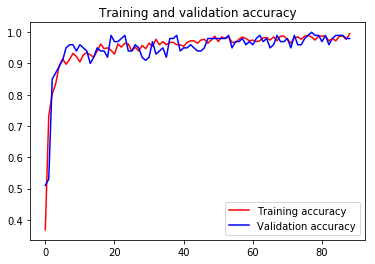

<Figure size 432x288 with 0 Axes>

In [ ]:
#show graph for model BEFORE fine tuning the Inception Model
import matplotlib.pyplot as plt

#get loss and accuracy values for the model
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

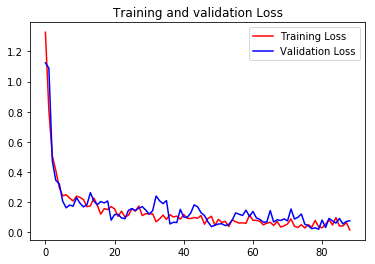

<Figure size 432x288 with 0 Axes>

In [ ]:
#show graph for model loss
import matplotlib.pyplot as plt

#get loss and accuracy values for the model
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
#test an image against the model
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)

  classes = model.predict(x, batch_size=10)
  print(fn)
  print(classes)

Saving RS_Rust 2296.JPG to RS_Rust 2296.JPG
RS_Rust 2296.JPG
[[1. 0. 0. 0.]]


In [ ]:
#save bigger float model
filepath='/content/drive/My Drive/models/inception.h5'
model.save(filepath)
print('\n model saved to drive \n')


 model saved to drive 



In [ ]:
#load the model from drive
from tensorflow.keras.models import load_model

filepath='/content/drive/My Drive/models/inception.h5'
# load model
model = load_model(filepath)
print('\n model loaded \n')


 model loaded 



In [ ]:
# Convert to TensorFlow Lite model.
import tensorflow as tf

filepath='/content/drive/My Drive/models/inception.h5'
lite_model='/content/drive/My Drive/models/inception_quant.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model_file(filepath)
#quantize the model
converter.post_training_quantize = True
tflite_model = converter.convert()
open(lite_model, "wb").write(tflite_model)
print('model converted')

In [ ]:
import tensorflow as tf
print(tf.__version__)